# PyTorch LSTM Example on Sin(t) Waveform Prediction
- Network & Solver definition
- Mini-Batch Training & Testing
- Inifnite time sequence inference
- Iterative Finetuning

Example equivalent to Caffe example https://github.com/CorvusCorax/Caffe-LSTM-Mini-Tutorial<br>
which is based on http://www.xiaoliangbai.com/2018/01/30/Caffe-LSTM-SinWaveform-Batch by Xiaoliang Bai.<br>

In [1]:
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
use_cuda = True

torch.manual_seed(0x1010)
np.random.seed(0x1010)
device = torch.device("cuda" if use_cuda else "cpu")


In [3]:
# Use the sample generator from Tensorflow Sin(t) online
def generate_sample(f = 1.0, t0 = None, batch_size = 1, predict = 50, samples = 100):
    """
    Generates data samples.

    :param f: The frequency to use for all time series or None to randomize.
    :param t0: The time offset to use for all time series or None to randomize.
    :param batch_size: The number of time series to generate.
    :param predict: The number of future samples to generate.
    :param samples: The number of past (and current) samples to generate.
    :return: Tuple that contains the past times and values as well as the future times and values. In all outputs,
             each row represents one time series of the batch.
    """
    Fs = 100.0

    T = np.empty((batch_size, samples))
    Y = np.empty((batch_size, samples))
    FT = np.empty((batch_size, predict))
    FY = np.empty((batch_size, predict))

    _t0 = t0
    for i in range(batch_size):
        t = np.arange(0, samples + predict) / Fs
        if _t0 is None:
            t0 = np.random.rand() * 2 * np.pi
        else:
            t0 = _t0 + i/float(batch_size)

        freq = f
        if freq is None:
            freq = np.random.rand() * 3.5 + 0.5

        y = np.sin(2 * np.pi * freq * (t + t0))

        T[i, :] = t[0:samples]
        Y[i, :] = y[0:samples]

        FT[i, :] = t[samples:samples + predict]
        FY[i, :] = y[samples:samples + predict]

    return T, Y, FT, FY

In [4]:
snapshot_prefix = 'lstm_demo_snapshot'
# Network Parameters
n_input = 1 # single input stream
n_steps = 100 # timesteps
n_hidden = 15 # hidden units in LSTM
n_outputs = 50 # predictions in future time
batch_size = 20 # batch of data
NO_INPUT_DATA = -2 # defined numeric value for network if no input data is available
# Training Parameters
n_train = 6000
n_display = 200
n_adamAlpha = 0.001
n_adamEpsilon = 0.02

## Training Network definition

In [5]:
class LSTMDemoNetwork(torch.nn.Module):

    n_hidden = None
    hx = (None,None)
    
    # n_input is input timesteps, n_hidden is LSTM units, n_output is output timesteps
    def __init__(self, n_hidden):
        super(LSTMDemoNetwork, self).__init__()
        self.n_hidden=n_hidden
        
        self.lstm = torch.nn.LSTM(1,self.n_hidden,num_layers=1)
        self.ip1 = torch.nn.Linear(self.n_hidden,1)
        
        self.init_weights()
        
    def forward(self, x, hx=None):
        
        out, thx = self.lstm(x,hx=hx)
        self.hx = (thx[0].detach(),thx[1].detach())
        out = self.ip1(out)
        return out
    
    def init_weights(self):
        # Initialize forget gate bias to 1
        #
        # from https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        #    .. math::
        #    \begin{array}{ll} \\
        #        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
        #        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
        #        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
        #        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
        #        c_t = f_t * c_{(t-1)} + i_t * g_t \\
        #        h_t = o_t * \tanh(c_t) \\
        #    \end{array}
        #...
        #    Attributes:
        #    weight_ih_l[k] : the learnable input-hidden weights of the :math:`\text{k}^{th}` layer
        #      `(W_ii|W_if|W_ig|W_io)`, of shape `(4*hidden_size, input_size)` for `k = 0`.
        #       Otherwise, the shape is `(4*hidden_size, num_directions * hidden_size)`
        #    weight_hh_l[k] : the learnable hidden-hidden weights of the :math:`\text{k}^{th}` layer
        #      `(W_hi|W_hf|W_hg|W_ho)`, of shape `(4*hidden_size, hidden_size)`
        #    bias_ih_l[k] : the learnable input-hidden bias of the :math:`\text{k}^{th}` layer
        #      `(b_ii|b_if|b_ig|b_io)`, of shape `(4*hidden_size)`
        #    bias_hh_l[k] : the learnable hidden-hidden bias of the :math:`\text{k}^{th}` layer
        #      `(b_hi|b_hf|b_hg|b_ho)`, of shape `(4*hidden_size)`
        #
        #
        # This is a common trick to speed up LSTM training.
        # Unfortunately Pytorch does not offer selective weight initialisation in the layer definition.
        
        #print(self.lstm.state_dict().keys())
        param = getattr(self.lstm, 'bias_hh_l0')
        param.data[self.n_hidden:2*self.n_hidden] = 1
        # IMPORTANT! For some reason Pytorch uses two bias terms in each term of the LSTM cell
        # this is not only unnecessary and increases the number of learnable parameters
        # it also makes training less stable when compared to caffe1
        # we force bias_ih to 0 and set learning rate to 0 as well
        param = getattr(self.lstm, 'bias_ih_l0')
        param.data[:] = 0
        param.requires_grad = False

        


In [6]:
lstmModel = LSTMDemoNetwork(n_hidden).to(device)

In [7]:
lossFunction = torch.nn.MSELoss().to(device)

In [8]:
optimizer = torch.optim.Adam(lstmModel.parameters(),lr=n_adamAlpha,eps=n_adamEpsilon)

## Training

step  0 , loss =  0.6100238561630249
step  200 , loss =  0.46383559703826904 , avg loss =  0.5117676916718483
step  400 , loss =  0.35188817977905273 , avg loss =  0.4015021505951881
step  600 , loss =  0.27478936314582825 , avg loss =  0.29233527250587943
step  800 , loss =  0.21736185252666473 , avg loss =  0.23865433923900128
step  1000 , loss =  0.20815210044384003 , avg loss =  0.21169447161257268
step  1200 , loss =  0.18245530128479004 , avg loss =  0.19248730778694154
step  1400 , loss =  0.17951136827468872 , avg loss =  0.17836878329515457
step  1600 , loss =  0.1621991991996765 , avg loss =  0.1723385511338711
step  1800 , loss =  0.1653403639793396 , avg loss =  0.16596302539110183
step  2000 , loss =  0.1583380550146103 , avg loss =  0.162551117092371
step  2200 , loss =  0.1612466424703598 , avg loss =  0.1598108634352684
step  2400 , loss =  0.16245587170124054 , avg loss =  0.15708779029548167
step  2600 , loss =  0.15433980524539948 , avg loss =  0.1543604374676943
ste

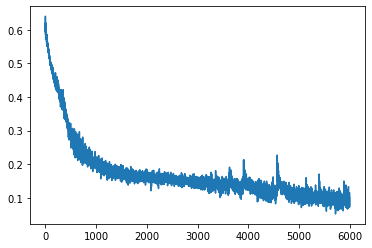

In [9]:
# Train network
def train_single(model, lf, solver, niter, disp_step):
    train_loss = np.zeros(niter) # this is for plotting, later
    
    
    unknown = torch.tensor(np.ones((n_outputs,batch_size), dtype=np.float32) * NO_INPUT_DATA).to(device)
    for i in range(niter):
        _, batch_x, _, batch_y = generate_sample(f=None,
                                         t0=None,
                                         batch_size=batch_size,
                                         samples=n_steps,
                                         predict=n_outputs)
        # IMPORTANT: Caffe LSTM has time in first dimension and batch in second, so
        # batched training data needs to be transposed
        # (This is from caffe examples, but unless batch_first has been passed to LSTM initializer, pytorch does the same thing)
        batch_x = torch.tensor(batch_x.transpose(),dtype=torch.float32).to(device)
        batch_y = torch.tensor(batch_y.transpose(),dtype=torch.float32).to(device)
        
        combined_x = torch.cat((batch_x,unknown)).view([n_steps+n_outputs,batch_size,1])
        combined_y = torch.cat((batch_x,batch_y)).view([n_steps+n_outputs,batch_size,1])
        
        result = model(combined_x)
        
        loss = lf(combined_y,result)
        
        train_loss[i] = loss.detach().cpu().numpy()
        
        solver.zero_grad()
        loss.backward()
        solver.step()
        
        if i % disp_step == 0:
            if i==0:
                print("step ", i, ", loss = ", train_loss[i])
            else:
                print("step ", i, ", loss = ", train_loss[i], ", avg loss = ", np.average(train_loss[i-disp_step:i]))
    print("Finished training, iteration reached ", niter, " final loss = ", train_loss[niter-1],
        " final avg = ", np.average(train_loss[niter-disp_step:niter-1]))
    return train_loss

train_loss = train_single(lstmModel,lossFunction,optimizer,n_train,n_display)

#explicitly save snapshot if it has not been done yet
filename='%s_iter_%i.pt' % (snapshot_prefix,n_train)
print('saving snapshot to "%s"' % (filename))
torch.save(lstmModel.state_dict(),filename)

# plot loss value during training
plt.plot(np.arange(n_train), train_loss)
plt.show()

## Testing

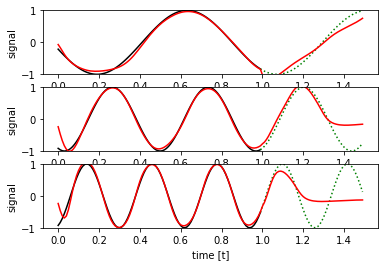

In [10]:
# Test the prediction with trained (unrolled) net
# we can change the batch size on the network at runtime, but not the number of timesteps (depth of unrolling)
def test_net(net,n_tests):
    batch_size = 1

    unknown = torch.tensor(np.ones((n_outputs,batch_size), dtype=np.float32) * NO_INPUT_DATA).to(device)
    for i in range(1, n_tests + 1):
        plt.subplot(n_tests, 1, i)
        t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
        test_input = torch.tensor(y.transpose(),dtype=torch.float32).to(device)
        combined_x = torch.cat((test_input,unknown)).view([n_steps+n_outputs,batch_size,1])
        expected_y = expected_y.reshape(n_outputs)
        
        prediction = net(combined_x).detach().cpu().numpy()
        
        # remove the batch size dimensions
        t = t.squeeze()
        y = y.squeeze()
        next_t = next_t.squeeze()
        t2 = np.append(t,next_t)
        prediction = prediction.squeeze()
        
        plt.plot(t, y, color='black')
        plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
        plt.plot(t2, prediction, color='red')
        plt.ylim([-1, 1])
        plt.xlabel('time [t]')
        plt.ylabel('signal')
    plt.show()
test_net(lstmModel,3)

## Inference / Validation

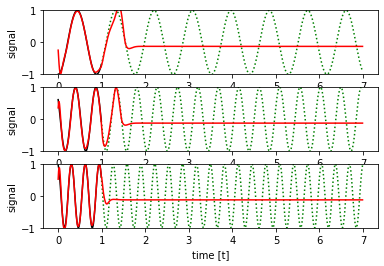

In [11]:
# the single step network can process infinite time series in a loop,
# as such we can increate n_outputs safely to have a glance at long term behaviour

def test_net_iterative(net,n_tests,n_outputs):
    for i in range(1, n_tests + 1):
        plt.subplot(n_tests, 1, i)
        t, y, next_t, expected_y = generate_sample(f=i+0.1337, t0=None, samples=n_steps, predict=n_outputs)
        expected_y = expected_y.reshape(n_outputs)

        prediction = []
        iA = np.zeros((1,1,1),dtype=np.float32)
        hx = None
        for T in range(n_steps):
            iA[0,0,0] = y[0,T].copy()
            x = torch.tensor(iA).to(device)
            yp = net(x,hx=hx).detach().cpu().numpy()
            hx = net.hx
            prediction.append(yp[0,0,0])
        
        for T in range(n_outputs):
            # in this case we have to manually indicate to the network
            # that there is no more input data at the current time step
            iA[0,0,0] = NO_INPUT_DATA
            x = torch.tensor(iA).to(device)
            yp = net(x,hx=hx).detach().cpu().numpy()
            hx = net.hx
            prediction.append(yp[0,0,0])
        
        # remove the batch size dimensions
        t = t.squeeze()
        y = y.squeeze()
        next_t = next_t.squeeze()
        t2 = np.append(t,next_t)
        prediction = np.array(prediction)
        
        plt.plot(t, y, color='black')
        plt.plot(np.append(t[-1], next_t), np.append(y[-1], expected_y), color='green', linestyle=":")
        plt.plot(t2, prediction, color='red')
        plt.ylim([-1, 1])
        plt.xlabel('time [t]')
        plt.ylabel('signal')
    plt.show()

test_net_iterative(lstmModel,3,600)

### Observation:
The network drifts towards a generic sine wave at constant frequency when left running for longer than the training sample size.
What happens if we train with a longer training window?

step  0 , loss =  0.5993098020553589
step  800 , loss =  0.36738312244415283 , avg loss =  0.4462436730414629
step  1600 , loss =  0.34903058409690857 , avg loss =  0.3582467787340283
step  2400 , loss =  0.3405740559101105 , avg loss =  0.33886114452034233
step  3200 , loss =  0.32634323835372925 , avg loss =  0.33354020312428473
step  4000 , loss =  0.3298587501049042 , avg loss =  0.33072057999670507
step  4800 , loss =  0.3283030688762665 , avg loss =  0.3287493133544922
step  5600 , loss =  0.3225407004356384 , avg loss =  0.3270166611671448
step  6400 , loss =  0.3237491548061371 , avg loss =  0.32480167396366594
step  7200 , loss =  0.3187989890575409 , avg loss =  0.3212342968955636
step  8000 , loss =  0.3114610016345978 , avg loss =  0.31326253194361925
step  8800 , loss =  0.30659493803977966 , avg loss =  0.3122813962772489
step  9600 , loss =  0.31901195645332336 , avg loss =  0.3151634018868208
step  10400 , loss =  0.29218778014183044 , avg loss =  0.30723592575639486
st

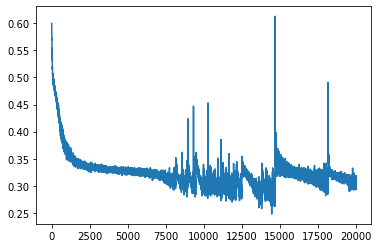

In [12]:
n_outputs = 200
n_train = 20000
snapshot_prefix = 'lstm_demo2_snapshot'

lstmModel = LSTMDemoNetwork(n_hidden).to(device)
optimizer = torch.optim.Adam(lstmModel.parameters(),lr=n_adamAlpha,eps=n_adamEpsilon)
train_loss = train_single(lstmModel,lossFunction,optimizer,n_train,800)

#explicitly save snapshot if it has not been done yet
filename='%s_iter_%i.pt' % (snapshot_prefix,n_train)
print('saving snapshot to "%s"' % (filename))
torch.save(lstmModel.state_dict(),filename)


plt.plot(np.arange(n_train), train_loss)
plt.show()

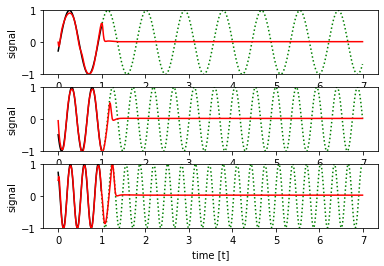

In [13]:
test_net_iterative(lstmModel,3,600)

### Observation:
With the longer unrolling window, the training converges much slower. The loss accumulated at the end of the window needs to backpropagate many steps until it reaches a timestep in which there is still a useful memory in the LSTM layer. This makes training potentially unstable.

A better option is to attempt iterative fine tuning with slowly increasing time windows. As a bonus, this allows doing most of the training with shorter windows, which means smaller networks and faster computation.

## Iterative Finetuning

initial training  50  ouput timesteps for  10000  training cycles
step  0 , loss =  0.5674645304679871
step  400 , loss =  0.30983877182006836 , avg loss =  0.42093255557119846
step  800 , loss =  0.24238353967666626 , avg loss =  0.25268871303647755
step  1200 , loss =  0.18918123841285706 , avg loss =  0.20987924225628377
step  1600 , loss =  0.18205870687961578 , avg loss =  0.18941344663500786
step  2000 , loss =  0.16308528184890747 , avg loss =  0.1753477780148387
step  2400 , loss =  0.1559123545885086 , avg loss =  0.16605412032455205
step  2800 , loss =  0.14058952033519745 , avg loss =  0.15445086445659398
step  3200 , loss =  0.13714367151260376 , avg loss =  0.14846248131245374
step  3600 , loss =  0.1421949714422226 , avg loss =  0.14334236338734627
step  4000 , loss =  0.13915038108825684 , avg loss =  0.1399128881841898
step  4400 , loss =  0.13092833757400513 , avg loss =  0.13678157048299908
step  4800 , loss =  0.11198166757822037 , avg loss =  0.13241701954975724
ste

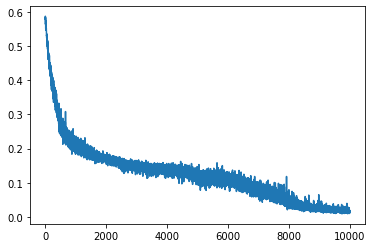

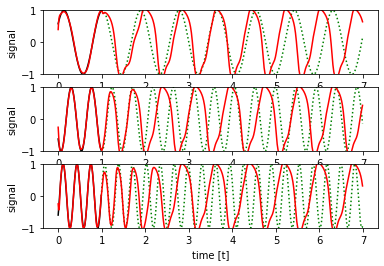

In [14]:
n_display = 400
n_outputs = 50
n_train = 10000

snapshot_prefix = 'lstm_demo3_0_snapshot'

print("initial training ", n_outputs," ouput timesteps for ",n_train," training cycles")

lstmModel = LSTMDemoNetwork(n_hidden).to(device)
optimizer = torch.optim.Adam(lstmModel.parameters(),lr=n_adamAlpha,eps=n_adamEpsilon)

train_loss = train_single(lstmModel,lossFunction,optimizer,n_train,n_display)

#explicitly save snapshot if it has not been done yet
filename='%s_iter_%i.pt' % (snapshot_prefix,n_train)
print('saving snapshot to "%s"' % (filename))
torch.save(lstmModel.state_dict(),filename)
net0=filename

plt.plot(np.arange(n_train), train_loss)
plt.show()

test_net_iterative(lstmModel,3,600)

initial training  100  ouput timesteps for  6000  training cycles
step  0 , loss =  0.07179751992225647
step  400 , loss =  0.04386515915393829 , avg loss =  0.061182753699831664
step  800 , loss =  0.09873643517494202 , avg loss =  0.04699650762602687
step  1200 , loss =  0.023680172860622406 , avg loss =  0.04237248070538044
step  1600 , loss =  0.04869146645069122 , avg loss =  0.037694152360782024
step  2000 , loss =  0.019881540909409523 , avg loss =  0.030602476422209292
step  2400 , loss =  0.024556143209338188 , avg loss =  0.030611779880709945
step  2800 , loss =  0.04189608246088028 , avg loss =  0.030109703775960953
step  3200 , loss =  0.01703086495399475 , avg loss =  0.030579789385665208
step  3600 , loss =  0.015673721209168434 , avg loss =  0.027010483865160494
step  4000 , loss =  0.05981170013546944 , avg loss =  0.025126901678740977
step  4400 , loss =  0.014695246703922749 , avg loss =  0.022143100197426976
step  4800 , loss =  0.013369301334023476 , avg loss =  0.0

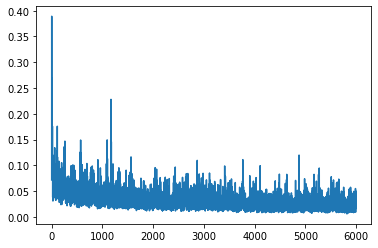

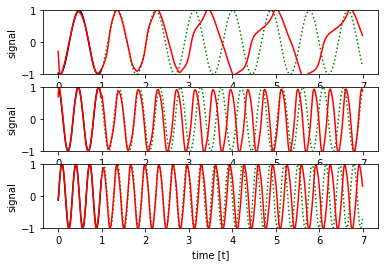

In [15]:
n_outputs = 100
n_train = 6000

snapshot_prefix = 'lstm_demo3_1_snapshot'

print("initial training ", n_outputs," ouput timesteps for ",n_train," training cycles")

lstmModel = LSTMDemoNetwork(n_hidden).to(device)
# load weights:
lstmModel.load_state_dict(torch.load(net0))
optimizer = torch.optim.Adam(lstmModel.parameters(),lr=n_adamAlpha,eps=n_adamEpsilon)

train_loss = train_single(lstmModel,lossFunction,optimizer,n_train,n_display)

#explicitly save snapshot if it has not been done yet
filename='%s_iter_%i.pt' % (snapshot_prefix,n_train)
print('saving snapshot to "%s"' % (filename))
torch.save(lstmModel.state_dict(),filename)
net1=filename

plt.plot(np.arange(n_train), train_loss)
plt.show()

test_net_iterative(lstmModel,3,600)

initial training  200  ouput timesteps for  8000  training cycles
step  0 , loss =  0.07823554426431656
step  400 , loss =  0.3082226812839508 , avg loss =  0.31507726760581134
step  800 , loss =  0.28302016854286194 , avg loss =  0.28704889595508576
step  1200 , loss =  0.23874340951442719 , avg loss =  0.2718718259036541
step  1600 , loss =  0.22829364240169525 , avg loss =  0.2529639072716236
step  2000 , loss =  0.18757495284080505 , avg loss =  0.24449665740132331
step  2400 , loss =  0.3054700791835785 , avg loss =  0.24931358870118855
step  2800 , loss =  0.2238008826971054 , avg loss =  0.2374013230577111
step  3200 , loss =  0.11111718416213989 , avg loss =  0.19704528357833623
step  3600 , loss =  0.09020867943763733 , avg loss =  0.15532408263534309
step  4000 , loss =  0.15085208415985107 , avg loss =  0.10852161114104092
step  4400 , loss =  0.06994427740573883 , avg loss =  0.09443443451076745
step  4800 , loss =  0.0706186443567276 , avg loss =  0.0783108841907233
step  

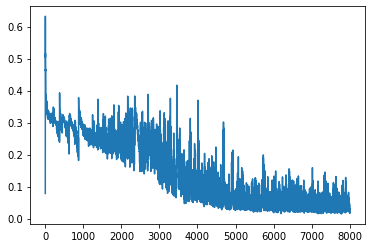

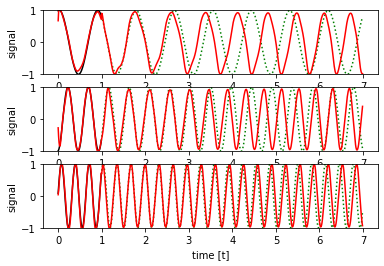

In [18]:
n_outputs = 200
n_train = 8000

snapshot_prefix = 'lstm_demo3_2_snapshot'

print("initial training ", n_outputs," ouput timesteps for ",n_train," training cycles")

lstmModel = LSTMDemoNetwork(n_hidden).to(device)
# load weights:
lstmModel.load_state_dict(torch.load(net1))
optimizer = torch.optim.Adam(lstmModel.parameters(),lr=n_adamAlpha,eps=n_adamEpsilon)

train_loss = train_single(lstmModel,lossFunction,optimizer,n_train,n_display)

#explicitly save snapshot if it has not been done yet
filename='%s_iter_%i.pt' % (snapshot_prefix,n_train)
print('saving snapshot to "%s"' % (filename))
torch.save(lstmModel.state_dict(),filename)
net2=filename

plt.plot(np.arange(n_train), train_loss)
plt.show()

test_net_iterative(lstmModel,3,600)

initial training  400  ouput timesteps for  20000  training cycles
step  0 , loss =  0.2417384684085846
step  400 , loss =  0.3802364766597748 , avg loss =  0.3961190339922905
step  800 , loss =  0.36070266366004944 , avg loss =  0.34978813380002977
step  1200 , loss =  0.31221869587898254 , avg loss =  0.3209123172610998
step  1600 , loss =  0.31287479400634766 , avg loss =  0.3358392792195082
step  2000 , loss =  0.37020471692085266 , avg loss =  0.3133617028594017
step  2400 , loss =  0.318511426448822 , avg loss =  0.3158454853668809
step  2800 , loss =  0.3617900311946869 , avg loss =  0.3181963883712888
step  3200 , loss =  0.23838287591934204 , avg loss =  0.3042260016128421
step  3600 , loss =  0.24795377254486084 , avg loss =  0.29421926647424695
step  4000 , loss =  0.21419012546539307 , avg loss =  0.2833383076637983
step  4400 , loss =  0.37373048067092896 , avg loss =  0.2854553144797683
step  4800 , loss =  0.3574375510215759 , avg loss =  0.2726440889015794
step  5200 , 

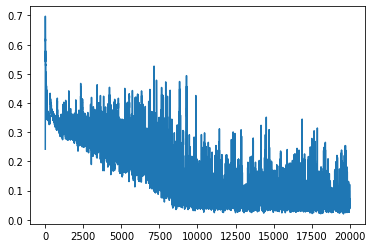

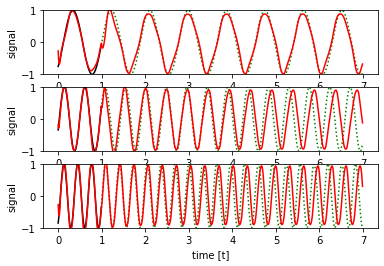

In [23]:
n_outputs = 400
n_train = 20000

snapshot_prefix = 'lstm_demo3_2_snapshot'

print("initial training ", n_outputs," ouput timesteps for ",n_train," training cycles")

lstmModel = LSTMDemoNetwork(n_hidden).to(device)
# load weights:
lstmModel.load_state_dict(torch.load(net2))
optimizer = torch.optim.Adam(lstmModel.parameters(),lr=n_adamAlpha/2,eps=n_adamEpsilon*2)

train_loss = train_single(lstmModel,lossFunction,optimizer,n_train,n_display)

#explicitly save snapshot if it has not been done yet
filename='%s_iter_%i.pt' % (snapshot_prefix,n_train)
print('saving snapshot to "%s"' % (filename))
torch.save(lstmModel.state_dict(),filename)
net3=filename

plt.plot(np.arange(n_train), train_loss)
plt.show()

test_net_iterative(lstmModel,3,600)

### Long term test

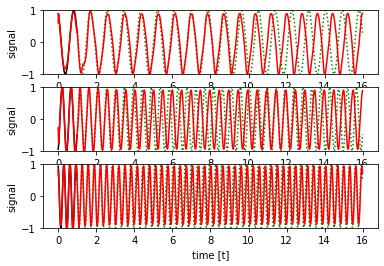

In [25]:
test_net_iterative(lstmModel,3,1500)

Trained with sufficient long unrolled time window, the resulting network is capable of identifying frequency and phase of the sin() wave with high accuracy and generate a time-stable reproduction.